### 🔧 Section 1: Environment Setup and Imports

In [1]:
# Cloning MobileSAM from your local path is not required since it's already available on disk.
# We'll now import essential libraries for data handling, image processing, and training.
import os
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch import nn
import tifffile  # for loading high-resolution masks

# Detect and use GPU if available, fallback to CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Computation device in use: {device}')

Computation device in use: cuda


### 📂 Section 2: Load and Organize Dataset Paths

In [2]:
# Function to collect all image and mask file paths from the dataset
def collect_image_mask_paths(base_dir):
    all_images, all_masks = [], []
    for organ in os.listdir(base_dir):
        img_dir = os.path.join(base_dir, organ, 'tissue images')
        mask_dir = os.path.join(base_dir, organ, 'label masks')
        if not os.path.isdir(img_dir) or not os.path.isdir(mask_dir):
            continue
        image_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
        mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
        if len(image_files) == len(mask_files):
            all_images.extend(image_files)
            all_masks.extend(mask_files)
    return all_images, all_masks

dataset_base = r'C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final\data'
image_files, mask_files = collect_image_mask_paths(dataset_base)

# Display count and sample pair for verification
print(f'Total image-mask pairs found: {len(image_files)}')
print('Sample image:', image_files[10])
print('Sample mask :', mask_files[10])

Total image-mask pairs found: 665
Sample image: C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final\data\human bladder\tissue images\human_bladder_11.png
Sample mask : C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final\data\human bladder\label masks\human_bladder_11.tif


### 🖼️ Section 3: Visualize Image and Mask Samples

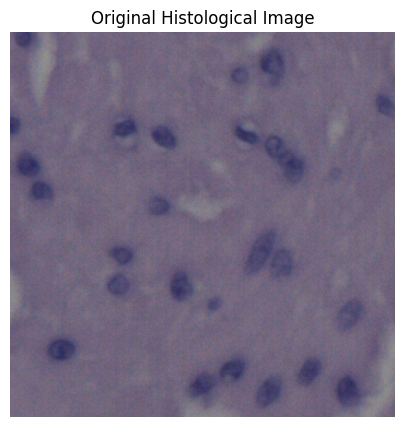

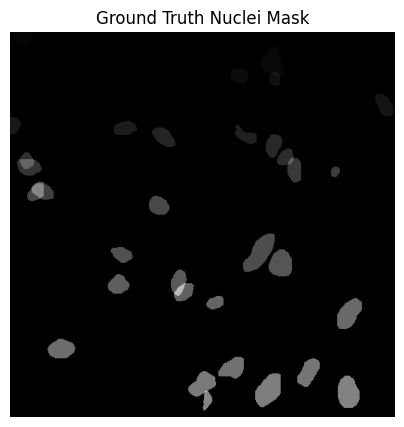

Mask shape: (512, 512)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 46 63]


In [3]:
# Let's look at a different sample (e.g., index 10) from the dataset
sample_index = 10
image = cv2.imread(image_files[sample_index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the selected H&E-stained image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title('Original Histological Image')
plt.axis('off')
plt.show()

# Load and show corresponding mask
mask = tifffile.imread(mask_files[sample_index])
plt.figure(figsize=(5,5))
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Nuclei Mask')
plt.axis('off')
plt.show()
# Also print some mask stats
print('Mask shape:', mask.shape)
print('Unique labels:', np.unique(mask))

In [4]:
# Create a custom dataset class for NuInsSeg images and masks
class NuInsSegDataset(Dataset):
    def __init__(self, images, masks, size=1024):
        """
        Initializes dataset with image paths, mask paths, and target resize size.
        """
        self.images = images
        self.masks = masks
        self.target_size = size

    def __len__(self):
        # Total number of image-mask pairs
        return len(self.images)

    def __getitem__(self, idx):
        """
        Loads and preprocesses the image and mask at index `idx`.
        """
        # Load and normalize the image
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.target_size, self.target_size))
        image_tensor = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        # Load and binarize the mask (foreground = nuclei)
        mask = tifffile.imread(self.masks[idx])
        mask = cv2.resize(mask, (self.target_size, self.target_size))
        mask_tensor = torch.tensor((mask > 0).astype(np.float32)).unsqueeze(0)

        return image_tensor, mask_tensor

# Initialize dataset object
full_dataset = NuInsSegDataset(image_files, mask_files)

# Check one processed sample visually
sample_img, sample_mask = full_dataset[10]
print("Sample image tensor shape:", sample_img.shape)
print("Sample mask tensor shape :", sample_mask.shape)


Sample image tensor shape: torch.Size([3, 1024, 1024])
Sample mask tensor shape : torch.Size([1, 1024, 1024])


In [5]:
# Prepare for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split dataset indices for training and validation
folds = list(kf.split(image_files))

# Just verifying split lengths
for i, (train_idx, val_idx) in enumerate(folds):
    print(f"Fold {i+1} -> Train: {len(train_idx)}, Val: {len(val_idx)}")


Fold 1 -> Train: 532, Val: 133
Fold 2 -> Train: 532, Val: 133
Fold 3 -> Train: 532, Val: 133
Fold 4 -> Train: 532, Val: 133
Fold 5 -> Train: 532, Val: 133


In [13]:
import sys
import peft
# Define your MobileSAM folder path again
mobilesam_path = r"C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final\MobileSAM"

# Now build the checkpoint path
checkpoint_path = os.path.join(mobilesam_path, "weights", "mobile_sam.pt")


# Add BOTH paths to sys.path
sys.path.append(r"C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final")
sys.path.append(r"C:\Users\umaim\Downloads\MED A3\MobileSAM\nuclei-sam-lora\MobileSAM_LoRA_NuInsSeg_Final\MobileSAM")

# Now you can safely import
from mobile_sam import sam_model_registry
from lora_utils import inject_lora, count_lora_parameters

from mobile_sam import sam_model_registry
from lora_utils import inject_lora, count_lora_parameters

# Load pre-trained MobileSAM
model_type = "vit_t"  # MobileSAM is a tiny ViT model
checkpoint_path = os.path.join(mobilesam_path, "weights/mobile_sam.pt")

# Register and load the model
sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)
print("✅ MobileSAM loaded successfully.")

# Inject LoRA into image encoder
inject_lora(sam_model.image_encoder)

# Count number of tunable parameters (as required in assignment)
tunable_params = count_lora_parameters(sam_model.image_encoder)
print(f"Total trainable parameters with LoRA: {tunable_params:,}")


c:\users\umaim\downloads\med a3\mobilesam\nuclei-sam-lora\mobilesam_lora_nuinsseg_final\mobilesam\mobile_sam\build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

✅ MobileSAM loaded successfully.
✅ LoRA successfully injected into MobileSAM encoder.
Total trainable parameters with LoRA: 59,392


In [14]:
# Choose one fold for demonstration
train_idx, val_idx = folds[0]

# Get image and mask subsets
train_imgs = [image_files[i] for i in train_idx]
train_masks = [mask_files[i] for i in train_idx]
val_imgs = [image_files[i] for i in val_idx]
val_masks = [mask_files[i] for i in val_idx]

# Create dataset and dataloaders
train_set = NuInsSegDataset(train_imgs, train_masks)
val_set = NuInsSegDataset(val_imgs, val_masks)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2)

print("📦 Dataloaders for 1 fold are ready.")


📦 Dataloaders for 1 fold are ready.


In [17]:
# 🧪 Dice Loss Implementation
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target, smooth=1e-5):
        pred = torch.sigmoid(pred)  # convert raw logits to probabilities
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()  # return 1 - Dice score as loss

# 🎯 Loss and Optimizer Setup
loss_fn = DiceLoss()
optimizer = torch.optim.AdamW(sam_model.image_encoder.parameters(), lr=1e-4)
num_epochs = 5  # You can increase epochs for better convergence

# ⚙️ Dynamically infer feature size and define decoder
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 1024, 1024).to(device)
    dummy_features = sam_model.image_encoder(dummy_input)
    feature_channels = dummy_features.shape[1]

decoder = nn.Conv2d(feature_channels, 1, kernel_size=1).to(device)

# 🔁 One Fold Training Loop
for epoch in range(num_epochs):
    sam_model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()

        # Forward pass through encoder
        features = sam_model.image_encoder(imgs)

        # Decode + Upsample to 1024×1024
        preds = decoder(features)
        preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)

        # Compute loss
        loss = loss_fn(preds_upsampled, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 🧪 Validation Loop
    sam_model.eval()
    val_dice_scores = []

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validation"):
            imgs, masks = imgs.to(device), masks.to(device)

            features = sam_model.image_encoder(imgs)
            preds = decoder(features)
            preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)

            preds_bin = torch.sigmoid(preds_upsampled) > 0.5

            # Compute Dice score
            intersection = (preds_bin & (masks > 0.5)).float().sum((2, 3))
            union = preds_bin.float().sum((2, 3)) + (masks > 0.5).float().sum((2, 3))
            dice_score = (2 * intersection + 1e-5) / (union + 1e-5)
            val_dice_scores.append(dice_score.mean().item())

    print(f"📉 Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Dice = {np.mean(val_dice_scores):.4f}")


Validation: 100%|██████████| 67/67 [01:03<00:00,  1.06it/s]


📉 Epoch 1: Train Loss = 0.7725, Val Dice = 0.5696


Validation: 100%|██████████| 67/67 [00:29<00:00,  2.30it/s]


📉 Epoch 2: Train Loss = 0.7296, Val Dice = 0.5713


Validation: 100%|██████████| 67/67 [00:25<00:00,  2.61it/s]


📉 Epoch 3: Train Loss = 0.6833, Val Dice = 0.5332


Validation: 100%|██████████| 67/67 [01:28<00:00,  1.31s/it]


📉 Epoch 4: Train Loss = 0.6769, Val Dice = 0.5561


Validation: 100%|██████████| 67/67 [01:26<00:00,  1.28s/it]

📉 Epoch 5: Train Loss = 0.6732, Val Dice = 0.5745


In [19]:
# 🧪 Dice Loss Implementation
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target, smooth=1e-5):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

# 🎯 Setup
loss_fn = DiceLoss()
num_epochs = 5
batch_size = 2

# ⚙️ Dynamically infer feature size from encoder output
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 1024, 1024).to(device)
    dummy_features = sam_model.image_encoder(dummy_input)
    feature_channels = dummy_features.shape[1]

# Store Dice scores for all folds
all_fold_dice_scores = []

# 🔁 5-Fold Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(folds):
    print(f"\n🔀 Starting Fold {fold+1}/5")

    # Get fold-specific data
    train_imgs = [image_files[i] for i in train_idx]
    train_masks = [mask_files[i] for i in train_idx]
    val_imgs = [image_files[i] for i in val_idx]
    val_masks = [mask_files[i] for i in val_idx]

    # Datasets and DataLoaders
    train_set = NuInsSegDataset(train_imgs, train_masks)
    val_set = NuInsSegDataset(val_imgs, val_masks)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # Re-init decoder and optimizer for each fold
    decoder = nn.Conv2d(feature_channels, 1, kernel_size=1).to(device)
    optimizer = torch.optim+.AdamW(sam_model.image_encoder.parameters(), lr=1e-4)

    # 🔁 Training loop for current fold
    for epoch in range(num_epochs):
        sam_model.train()
        train_loss = 0

        for imgs, masks in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            features = sam_model.image_encoder(imgs)
            preds = decoder(features)
            preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)

            loss = loss_fn(preds_upsampled, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"📉 Fold {fold+1} | Epoch {epoch+1} — Train Loss: {train_loss/len(train_loader):.4f}")

    # 🧪 Validation for current fold
    sam_model.eval()
    val_dice_scores = []

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Fold {fold+1} | Validation"):
            imgs, masks = imgs.to(device), masks.to(device)

            features = sam_model.image_encoder(imgs)
            preds = decoder(features)
            preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)
            preds_bin = torch.sigmoid(preds_upsampled) > 0.5

            intersection = (preds_bin & (masks > 0.5)).float().sum((2, 3))
            union = preds_bin.float().sum((2, 3)) + (masks > 0.5).float().sum((2, 3))
            dice_score = (2 * intersection + 1e-5) / (union + 1e-5)
            val_dice_scores.append(dice_score.mean().item())

    fold_dice = np.mean(val_dice_scores)
    all_fold_dice_scores.append(fold_dice)
    print(f"✅ Fold {fold+1} Completed — Val Dice Score: {fold_dice:.4f}")

# 📊 Final Summary
print("\n📈 5-Fold Cross-Validation Dice Scores:")
for i, score in enumerate(all_fold_dice_scores):
    print(f"Fold {i+1}: {score:.4f}")
print(f"🔚 Average Dice Score: {np.mean(all_fold_dice_scores):.4f}")



🔀 Starting Fold 1/5


Fold 1 | Epoch 1/5: 100%|██████████| 266/266 [06:42<00:00,  1.51s/it]


📉 Fold 1 | Epoch 1 — Train Loss: 0.7202


Fold 1 | Epoch 2/5: 100%|██████████| 266/266 [06:18<00:00,  1.42s/it]


📉 Fold 1 | Epoch 2 — Train Loss: 0.6959


Fold 1 | Epoch 3/5: 100%|██████████| 266/266 [06:25<00:00,  1.45s/it]


📉 Fold 1 | Epoch 3 — Train Loss: 0.6909


Fold 1 | Epoch 4/5: 100%|██████████| 266/266 [06:05<00:00,  1.37s/it]


📉 Fold 1 | Epoch 4 — Train Loss: 0.6849


Fold 1 | Epoch 5/5: 100%|██████████| 266/266 [06:00<00:00,  1.35s/it]


📉 Fold 1 | Epoch 5 — Train Loss: 0.6832


Fold 1 | Validation: 100%|██████████| 67/67 [01:01<00:00,  1.09it/s]


✅ Fold 1 Completed — Val Dice Score: 0.5349

🔀 Starting Fold 2/5


Fold 2 | Epoch 1/5: 100%|██████████| 266/266 [06:28<00:00,  1.46s/it]


📉 Fold 2 | Epoch 1 — Train Loss: 0.7197


Fold 2 | Epoch 2/5: 100%|██████████| 266/266 [06:11<00:00,  1.40s/it]


📉 Fold 2 | Epoch 2 — Train Loss: 0.6977


Fold 2 | Epoch 3/5: 100%|██████████| 266/266 [06:00<00:00,  1.35s/it]


📉 Fold 2 | Epoch 3 — Train Loss: 0.6930


Fold 2 | Epoch 4/5: 100%|██████████| 266/266 [06:45<00:00,  1.52s/it]


📉 Fold 2 | Epoch 4 — Train Loss: 0.6900


Fold 2 | Epoch 5/5: 100%|██████████| 266/266 [08:17<00:00,  1.87s/it]


📉 Fold 2 | Epoch 5 — Train Loss: 0.6884


Fold 2 | Validation: 100%|██████████| 67/67 [01:29<00:00,  1.34s/it]


✅ Fold 2 Completed — Val Dice Score: 0.2820

🔀 Starting Fold 3/5


Fold 3 | Epoch 1/5: 100%|██████████| 266/266 [10:11<00:00,  2.30s/it]


📉 Fold 3 | Epoch 1 — Train Loss: 0.7043


Fold 3 | Epoch 2/5: 100%|██████████| 266/266 [10:23<00:00,  2.35s/it]


📉 Fold 3 | Epoch 2 — Train Loss: 0.6893


Fold 3 | Epoch 3/5: 100%|██████████| 266/266 [10:19<00:00,  2.33s/it]


📉 Fold 3 | Epoch 3 — Train Loss: 0.6844


Fold 3 | Epoch 4/5: 100%|██████████| 266/266 [10:17<00:00,  2.32s/it]


📉 Fold 3 | Epoch 4 — Train Loss: 0.6811


Fold 3 | Epoch 5/5: 100%|██████████| 266/266 [10:22<00:00,  2.34s/it]


📉 Fold 3 | Epoch 5 — Train Loss: 0.6780


Fold 3 | Validation: 100%|██████████| 67/67 [01:27<00:00,  1.31s/it]


✅ Fold 3 Completed — Val Dice Score: 0.2477

🔀 Starting Fold 4/5


Fold 4 | Epoch 1/5: 100%|██████████| 266/266 [10:19<00:00,  2.33s/it]


📉 Fold 4 | Epoch 1 — Train Loss: 0.7075


Fold 4 | Epoch 2/5: 100%|██████████| 266/266 [10:19<00:00,  2.33s/it]


📉 Fold 4 | Epoch 2 — Train Loss: 0.6795


Fold 4 | Epoch 3/5: 100%|██████████| 266/266 [09:16<00:00,  2.09s/it]


📉 Fold 4 | Epoch 3 — Train Loss: 0.6746


Fold 4 | Epoch 4/5: 100%|██████████| 266/266 [06:00<00:00,  1.36s/it]


📉 Fold 4 | Epoch 4 — Train Loss: 0.6706


Fold 4 | Epoch 5/5: 100%|██████████| 266/266 [05:55<00:00,  1.34s/it]


📉 Fold 4 | Epoch 5 — Train Loss: 0.6685


Fold 4 | Validation: 100%|██████████| 67/67 [00:52<00:00,  1.28it/s]


✅ Fold 4 Completed — Val Dice Score: 0.5631

🔀 Starting Fold 5/5


Fold 5 | Epoch 1/5: 100%|██████████| 266/266 [06:00<00:00,  1.36s/it]


📉 Fold 5 | Epoch 1 — Train Loss: 0.6899


Fold 5 | Epoch 2/5: 100%|██████████| 266/266 [05:55<00:00,  1.34s/it]


📉 Fold 5 | Epoch 2 — Train Loss: 0.6745


Fold 5 | Epoch 3/5: 100%|██████████| 266/266 [05:57<00:00,  1.34s/it]


📉 Fold 5 | Epoch 3 — Train Loss: 0.6715


Fold 5 | Epoch 4/5: 100%|██████████| 266/266 [05:58<00:00,  1.35s/it]


📉 Fold 5 | Epoch 4 — Train Loss: 0.6709


Fold 5 | Epoch 5/5: 100%|██████████| 266/266 [05:55<00:00,  1.34s/it]


📉 Fold 5 | Epoch 5 — Train Loss: 0.6694


Fold 5 | Validation: 100%|██████████| 67/67 [00:52<00:00,  1.27it/s]

✅ Fold 5 Completed — Val Dice Score: 0.5053

📈 5-Fold Cross-Validation Dice Scores:
Fold 1: 0.5349
Fold 2: 0.2820
Fold 3: 0.2477
Fold 4: 0.5631
Fold 5: 0.5053
🔚 Average Dice Score: 0.4266


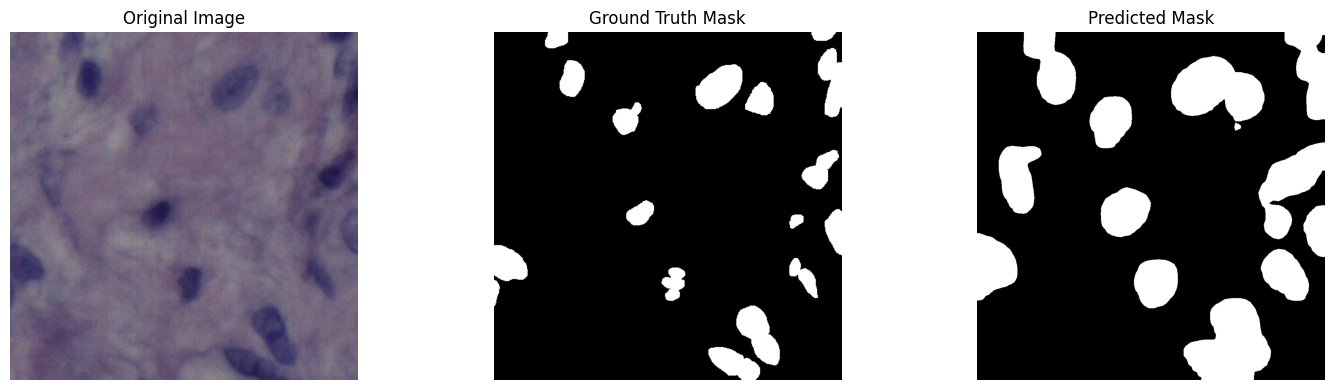

In [18]:
import matplotlib.pyplot as plt

# Pick a batch from validation loader to visualize
sam_model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)

with torch.no_grad():
    features = sam_model.image_encoder(imgs)
    preds = decoder(features)
    preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)
    preds_bin = torch.sigmoid(preds_upsampled) > 0.5

# Convert tensors to numpy for plotting
img_np = imgs[0].permute(1, 2, 0).cpu().numpy()
mask_np = masks[0][0].cpu().numpy()
pred_np = preds_bin[0][0].cpu().numpy()

# Plot side-by-side
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


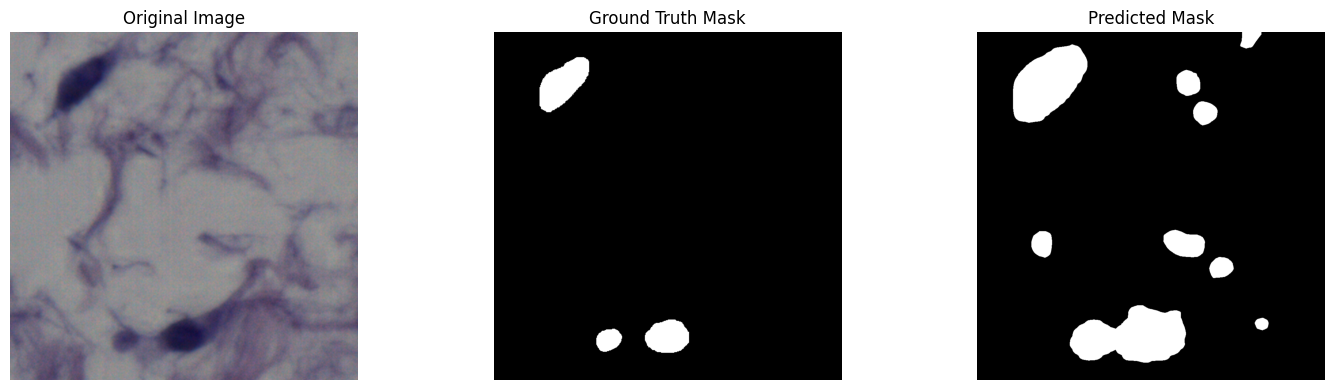

In [20]:
import matplotlib.pyplot as plt

# Pick a batch from validation loader to visualize
sam_model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)

with torch.no_grad():
    features = sam_model.image_encoder(imgs)
    preds = decoder(features)
    preds_upsampled = nn.functional.interpolate(preds, size=(1024, 1024), mode='bilinear', align_corners=False)
    preds_bin = torch.sigmoid(preds_upsampled) > 0.5

# Convert tensors to numpy for plotting
img_np = imgs[0].permute(1, 2, 0).cpu().numpy()
mask_np = masks[0][0].cpu().numpy()
pred_np = preds_bin[0][0].cpu().numpy()

# Plot side-by-side
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
